In [4]:
!pip install diffusers transformers accelerate safetensors --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [5]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'Tesla T4')

In [15]:
from diffusers import StableDiffusionPipeline
from transformers import pipeline
import gradio as gr
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
import matplotlib.pyplot as plt
import gc
from google.colab import files
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from diffusers import StableDiffusionInstructPix2PixPipeline
from PIL import Image
import torch
import torchvision.transforms as T
import os
from diffusers.utils import export_to_video

In [7]:
def clear_mem(_pipe):
  del _pipe
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.ipc_collect()  # <= важ

# Потестируем Текст в Изображение

- runwayml/stable-diffusion-v1-5 | ~4.27 GB | Стандартная SD, рисует качественно и быстро.
- stabilityai/sdxl-turbo | ~2.74 GB | Быстрая генерация 512x512 изображений.
- dreamlike-art/dreamlike-photoreal-2.0 | ~7.5 GB | Фотореалистичная генерация.
- prompthero/openjourney | ~4.2 GB | В стиле Midjourney.
- nitrosocke/mo-di-diffusion | ~4.2 GB | В стиле аниме/диснея.
- black-forest-labs/FLUX.1-dev | ~32 GB |

| Модель                                                                                                  | Размер  | Float16 | Torch ≤2.5 | Safetensors | VRAM  | Вывод    |
| ------------------------------------------------------------------------------------------------------- | ------- | ------- | ---------- | ----------- | ----- | -------- |
| [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5)               | 4.27 GB | ✅       | ✅          | ✅           | 6 GB  | 🖼 image |
| [`stabilityai/sdxl-turbo`](https://huggingface.co/stabilityai/sdxl-turbo)                               | 2.7 GB  | ✅       | ❌          | ✅           | 8 GB  | 🖼 image |
| [`dreamlike-art/dreamlike-photoreal-2.0`](https://huggingface.co/dreamlike-art/dreamlike-photoreal-2.0) | 7.5 GB  | ✅       | ✅          | ✅           | 10 GB | 🖼 image |
| [`prompthero/openjourney`](https://huggingface.co/prompthero/openjourney)                               | 4.2 GB  | ✅       | ✅          | ❌           | 6 GB  | 🖼 image |
| [`nitrosocke/mo-di-diffusion`](https://huggingface.co/nitrosocke/mo-di-diffusion)                       | 4.2 GB  | ✅       | ✅          | ❌           | 6 GB  | 🖼 image |

In [6]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float32,
    safety_checker=None  # Отключаем фильтр
).to("cuda")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [7]:
image = pipe("10 blue deer drinking vodka in a forest bar").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

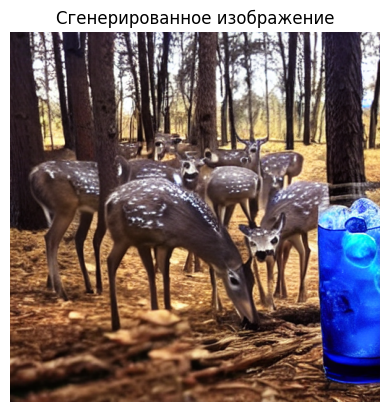

In [10]:
plt.imshow(image)
plt.axis('off')
plt.title("Сгенерированное изображение")
plt.show

In [19]:
clear_mem(pipe)

In [20]:
pipe2 = StableDiffusionPipeline.from_pretrained(
    "prompthero/openjourney",
    torch_dtype=torch.float32,
    safety_checker=None  # Отключаем фильтр
).to("cuda")


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [21]:
image2 = pipe2("10 blue deer drinking vodka in a forest bar").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

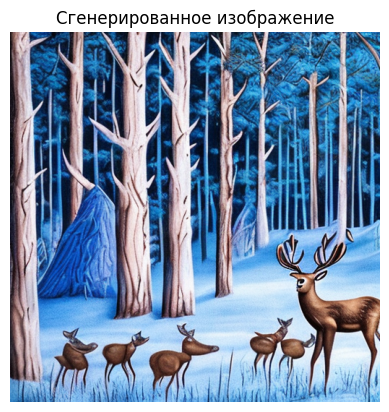

In [22]:
plt.imshow(image2)
plt.axis('off')
plt.title("Сгенерированное изображение")
plt.show

In [23]:
clear_mem(pipe2)

In [24]:
pipe3 = StableDiffusionPipeline.from_pretrained(
    "nitrosocke/mo-di-diffusion",
    torch_dtype=torch.float32,
    safety_checker=None  # Отключаем фильтр
).to("cuda")


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--nitrosocke--mo-di-diffusion/snapshots/e3106d24aa8c37bf856257daea2ae789eabc4d70/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diff

In [26]:
image3 = pipe3("10 blue deer drinking vodka in a forest bar").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

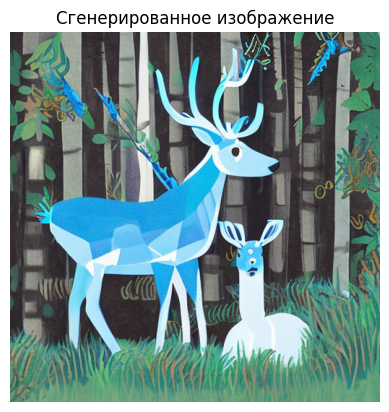

In [27]:
plt.imshow(image3)
plt.axis('off')
plt.title("Сгенерированное изображение")
plt.show

In [39]:
clear_mem(pipe3)

# Потестируем Изображение в текст.

🖼️ IMAGE → TEXT (image captioning / описание картинки)
Модель	Вес	Описание

- Salesforce/blip-image-captioning-base | ~215 MB | Быстрая и точная модель описания.
- Salesforce/blip2-opt-2.7b | ~5.4 GB | Мощная мультимодальная модель.
- nlpconnect/vit-gpt2-image-captioning | ~1.3 GB | Простая и хорошая caption-модель.
- microsoft/git-base | ~1.2 GB | Мультимодальная модель Microsoft.
- Salesforce/blip2-flan-t5-xl | ~10 GB | Captioning + VQA (вопросы к изображению).

| Модель                                                                                                  | Размер | Float16 | Torch ≤2.5 | Safetensors | VRAM  | Вывод   |
| ------------------------------------------------------------------------------------------------------- | ------ | ------- | ---------- | ----------- | ----- | ------- |
| [`Salesforce/blip-image-captioning-base`](https://huggingface.co/Salesforce/blip-image-captioning-base) | 215 MB | ❌       | ✅          | ❌           | 2 GB  | 📝 text |
| [`Salesforce/blip2-opt-2.7b`](https://huggingface.co/Salesforce/blip2-opt-2.7b)                         | 5.4 GB | ✅       | ✅          | ❌           | 10 GB | 📝 text |
| [`nlpconnect/vit-gpt2-image-captioning`](https://huggingface.co/nlpconnect/vit-gpt2-image-captioning)   | 1.3 GB | ❌       | ✅          | ❌           | 4 GB  | 📝 text |
| [`microsoft/git-base`](https://huggingface.co/microsoft/git-base)                                       | 1.2 GB | ❌       | ✅          | ❌           | 4 GB  | 📝 text |
| [`Salesforce/blip2-flan-t5-xl`](https://huggingface.co/Salesforce/blip2-flan-t5-xl)                     | 10 GB  | ✅       | ✅          | ❌           | 12 GB | 📝 text |

In [11]:
uploaded_image = files.upload()

Saving 1.jpeg to 1.jpeg


In [40]:
clear_mem(captioner)

In [41]:
captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base", device=0)

# Загружаем изображение
image = Image.open("1.jpeg").convert("RGB")

Device set to use cuda:0


<function matplotlib.pyplot.show(close=None, block=None)>

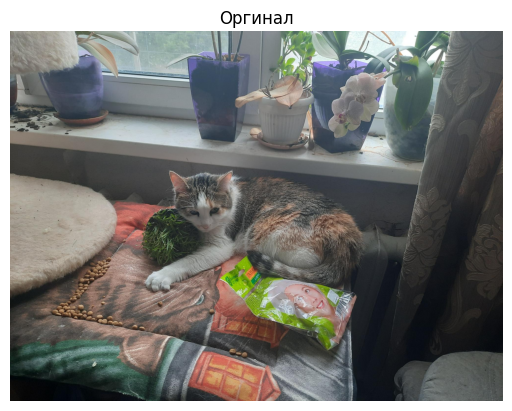

In [43]:
plt.imshow(image)
plt.axis('off')
plt.title("Оргинал")
plt.show

In [42]:
# Генерируем подпись
result = captioner(image)
print(result[0]["generated_text"])

a cat is sleeping on a pillow in a window sie


In [44]:
clear_mem(captioner)

In [45]:
captioner2 = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device=0)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Device set to use cuda:0


In [46]:
# Генерируем подпись
result2 = captioner2(image)
print(result2[0]["generated_text"])

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.


a cat sitting on a bed with a bunch of plants 


In [48]:
clear_mem(captioner2)

In [8]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,
).to("cuda")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [12]:
# Загружаем изображение
image = Image.open("1.jpeg").convert("RGB")

In [13]:
# Готовим input
inputs = processor(images=image, return_tensors="pt").to("cuda", torch.float16)

# Генерируем описание
out = model.generate(**inputs, max_new_tokens=30)
print(processor.decode(out[0], skip_special_tokens=True))

a cat laying on a blanket next to a window



In [14]:
clear_mem(inputs)

🎞️ IMAGE → VIDEO (анимация одного изображения)
- stabilityai/stable-video-diffusion-img2vid-xt | ~6.4 GB | Лучшая SVD-модель 2024.
- Wan-AI/Wan2.1-I2V-14B-720P-Diffusers | ~5.2 GB | Генерация 720p видео из картинки.
- cerspense/zeroscope_v2_576w | ~4.6 GB | Подходит как для text2video, так и img2video.
- ali-vilab/modelscope-text-to-video | ~2.7 GB | Работает и с картинкой как init.
- timbrooks/instruct-pix2pix | ~1.9 GB | Ближе к image-to-animation по prompt

| Модель                                                                                                                  | Размер | Float16 | Torch ≤2.5 | Safetensors | VRAM  | Вывод             |
| ----------------------------------------------------------------------------------------------------------------------- | ------ | ------- | ---------- | ----------- | ----- | ----------------- |
| [`stabilityai/stable-video-diffusion-img2vid-xt`](https://huggingface.co/stabilityai/stable-video-diffusion-img2vid-xt) | 6.4 GB | ✅       | ✅          | ✅           | 10 GB | 🎞 video          |
| [`Wan-AI/Wan2.1-I2V-14B-720P-Diffusers`](https://huggingface.co/Wan-AI/Wan2.1-I2V-14B-720P-Diffusers)                   | 5.2 GB | ✅       | ✅          | ✅           | 8 GB  | 🎞 video          |
| [`cerspense/zeroscope_v2_576w`](https://huggingface.co/cerspense/zeroscope_v2_576w)                                     | 4.6 GB | ❌       | ✅          | ❌           | 6 GB  | 🎞 video          |
| [`damo-vilab/modelscope-text-to-video`](https://huggingface.co/damo-vilab/modelscope-text-to-video)                     | 2.7 GB | ✅       | ✅          | ❌           | 6 GB  | 🎞 video          |
| [`timbrooks/instruct-pix2pix`](https://huggingface.co/timbrooks/instruct-pix2pix)                                       | 1.9 GB | ❌       | ✅          | ❌           | 4 GB  | 🖼/🎞 image/video |



In [18]:
# Загружаем модель
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")
pipe.enable_model_cpu_offload()


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Инструкции по кадрам (будут кадры типа morphing)
prompts = [
    "make it sunny",
    "make it sunset",
    "make it night",
    "add neon lights",
    "turn it into cyberpunk style"
]

frames = []

# Прогон по кадрам
for prompt in prompts:
    out = pipe(image=image, prompt=prompt, num_inference_steps=25, guidance_scale=8.5)
    frame = out.images[0]
    frames.append(frame)

# Сохраняем как видео
export_to_video(frames, "pix2pix_video.mp4", fps=2)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]